In [98]:
# Importações

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from src.config import DADOS_TRATADOS

In [99]:
# Obtendo os dados como DataFrame
df = pd.read_parquet(DADOS_TRATADOS)
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,...,10,4,7,0,0,0,0,0,0,1
1,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,...,1,2,5,0,0,0,0,0,0,0
2,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,2,10,4,0,0,0,0,0,0,0
3,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,...,0,4,6,0,0,0,0,0,0,0
4,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,3,6,5,0,0,0,0,0,0,0


In [100]:
# Resumo da base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197 entries, 0 to 2196
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Year_Birth           2197 non-null   int64         
 1   Education            2197 non-null   object        
 2   Marital_Status       2197 non-null   object        
 3   Income               2197 non-null   float64       
 4   Kidhome              2197 non-null   int64         
 5   Teenhome             2197 non-null   int64         
 6   Dt_Customer          2197 non-null   datetime64[ns]
 7   Recency              2197 non-null   int64         
 8   MntWines             2197 non-null   int64         
 9   MntFruits            2197 non-null   int64         
 10  MntMeatProducts      2197 non-null   int64         
 11  MntFishProducts      2197 non-null   int64         
 12  MntSweetProducts     2197 non-null   int64         
 13  MntGoldProds         2197 non-nul

Serão feitas análises específicas para cada natureza de atributos. 

Para os atributos de natureza numérica, serão analisados o histrograma e o boxplot

Para os atributos de natureza categórica, serão analisados as contagens de cada valor

In [101]:
# Definindo a natureza das colunas

nominal_categoric_columns = [
    "Marital_Status", 
    "Complain", 
    "Response",
    ] + df.columns[
        df.columns.str.startswith("Accepted")
    ].tolist()

ordinal_categoric_columns = [
    "Education", 
    "Kidhome", 
    "Teenhome",
    ]
categories_orders = [
    ["Basic", "2n Cycle", "Graduation", "Master", "PhD"],
    [0, 1, 2],
    [0, 1, 2],
]

numeric_columns = df.columns.difference(nominal_categoric_columns + ordinal_categoric_columns).tolist()

In [102]:
len(numeric_columns)

15

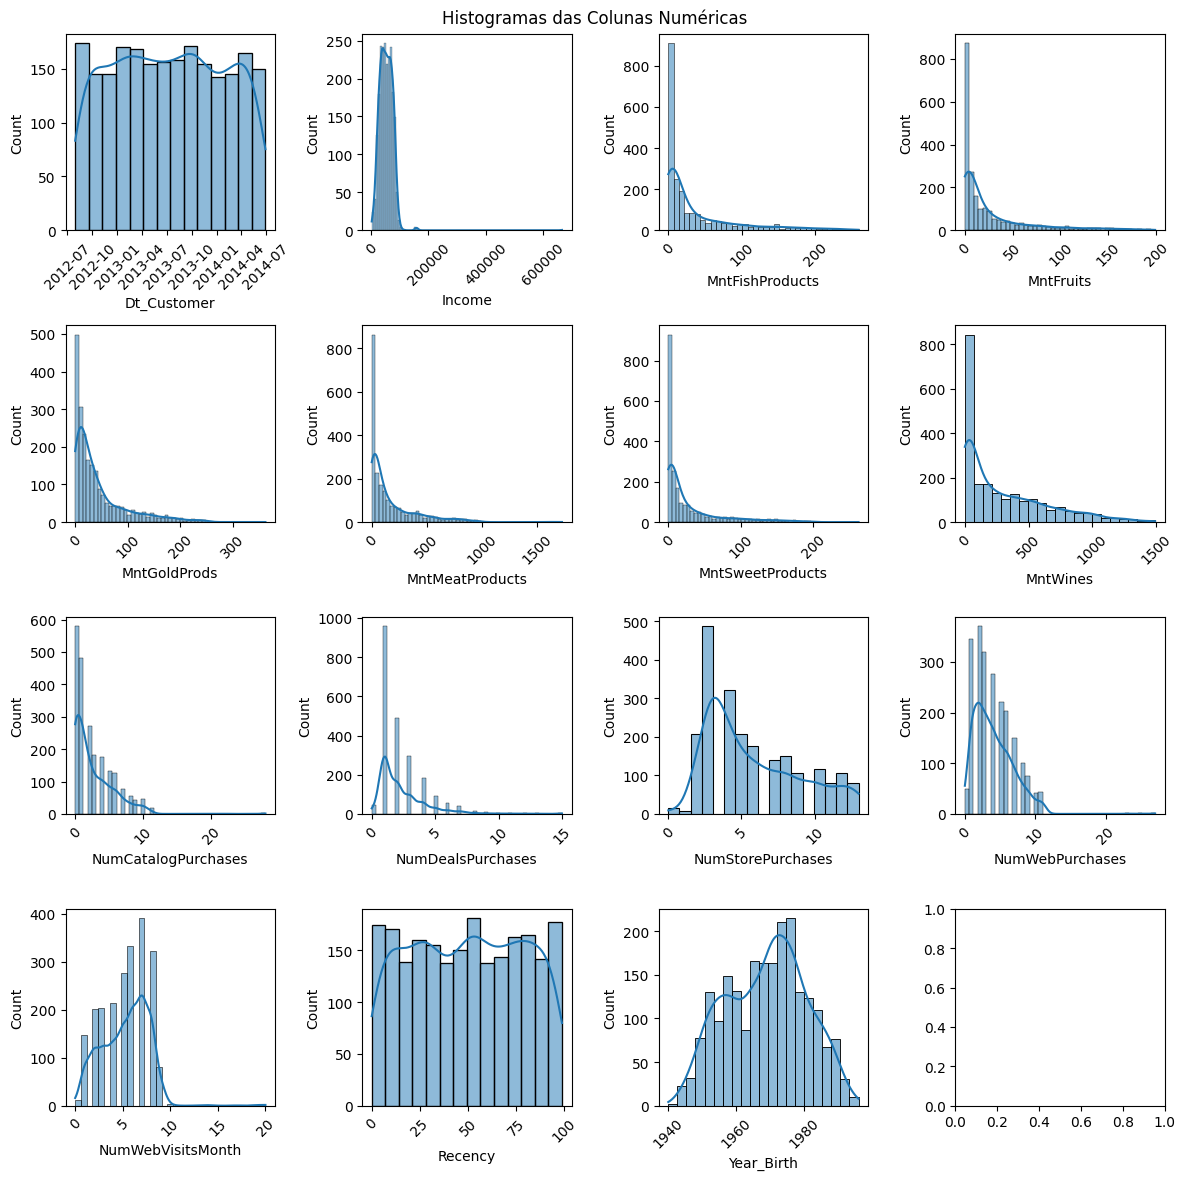

In [103]:
# Análise de histograma com atributos numéricos

fig, axs = plt.subplots(4, 4, figsize=(12, 12))

fig.suptitle("Histogramas das Colunas Numéricas")

for ax, column in zip(axs.flatten(), numeric_columns):

    sns.histplot(
        df,
        x=column,
        kde=True,
        ax=ax,
    )

    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

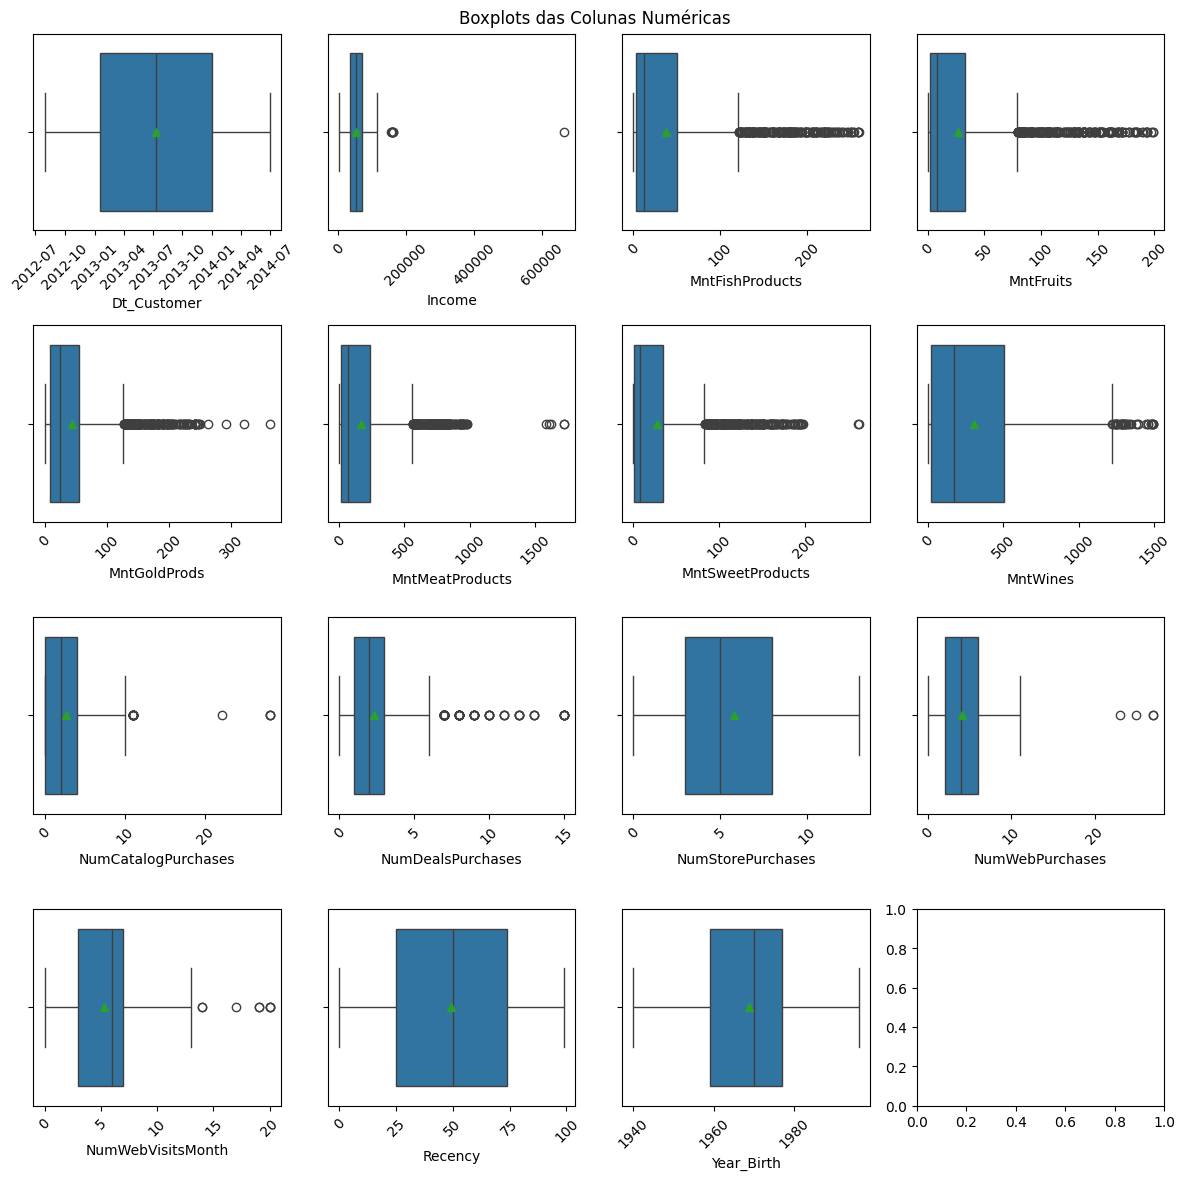

In [104]:
# Análise de boxplots com atributos numéricos

fig, axs = plt.subplots(4, 4, figsize=(12, 12))

fig.suptitle("Boxplots das Colunas Numéricas")

for ax, column in zip(axs.flatten(), numeric_columns):

    sns.boxplot(
        df,
        x=column,
        showmeans=True,
        ax=ax,
    )

    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Outliers próximos aos quartis e com "comportamento linear" não são tão problemáticos, pois não indicam ruído ao atributo.

Porém, outliers altamente discrepantes e com poucas ocorrências podem indicar ruído, e devem ser analisados com mais detalhes.

Nessa base, podem ser apontados nessa categoria:

- `Income`, para valores superiores a 60000
- `MntMeatProducts`, para valores superiores a 1500
- `MntSweetProducts`, para valores superiores a 200
- `NumCatalogPurchases`, para valores superiores a 20
- `NumWebPurchases`, para valores superiores a 20

Não removerei eles ainda, já que a base é altamente desbalanceada, e há riscos de remover ainda mais registros da classe minoritária de `Response`.

In [105]:
len(nominal_categoric_columns)

8

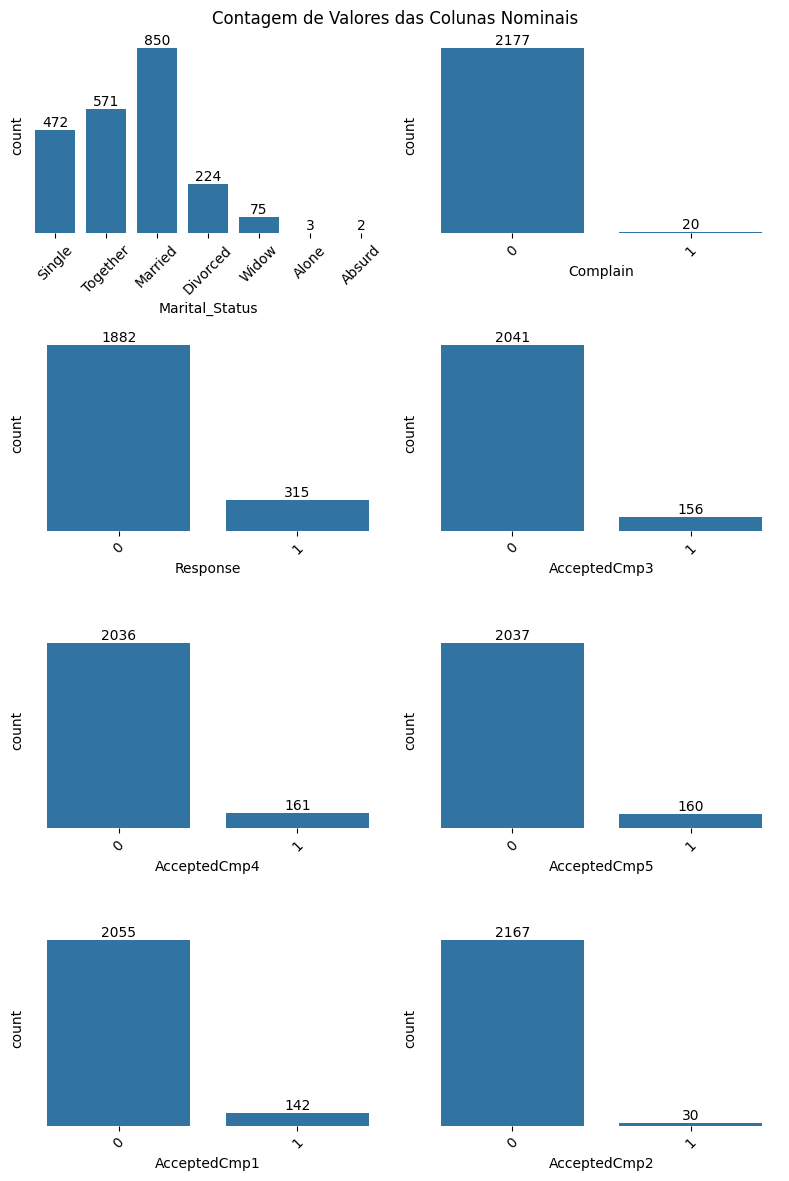

In [106]:
# Contagem de valores das colunas categóricas nominais

fig, axs = plt.subplots(4, 2, figsize=(8, 12))

fig.suptitle("Contagem de Valores das Colunas Nominais")

for ax, column in zip(axs.flatten(), nominal_categoric_columns):

    sns.countplot(
        df,
        x=column,
        ax=ax,
    )

    ax.tick_params(axis='x', rotation=45)
    ax.set_frame_on(False)

    ax.set_yticks([])

    for container in ax.containers:

        ax.bar_label(container)

plt.tight_layout()
plt.show()

Em `Marital_Status`, existem dois valores com poucas ocorrências e com pouca representatividade a base, que são 'Alone' e 'Absurd'. Durante a análise bivariata, será tomada a decisão se os registros com elas serão removidos ou se elas se juntarão a outras categorias.

As colunas `Complain` e `AcceptedCmp2` possuem uma predominância de valor 0. Além disso, elas são colunas binárias, o que impossibilita qualquer tipo de agregação. Logo, elas provavelmente serão removidas.

In [107]:
len(ordinal_categoric_columns)

3

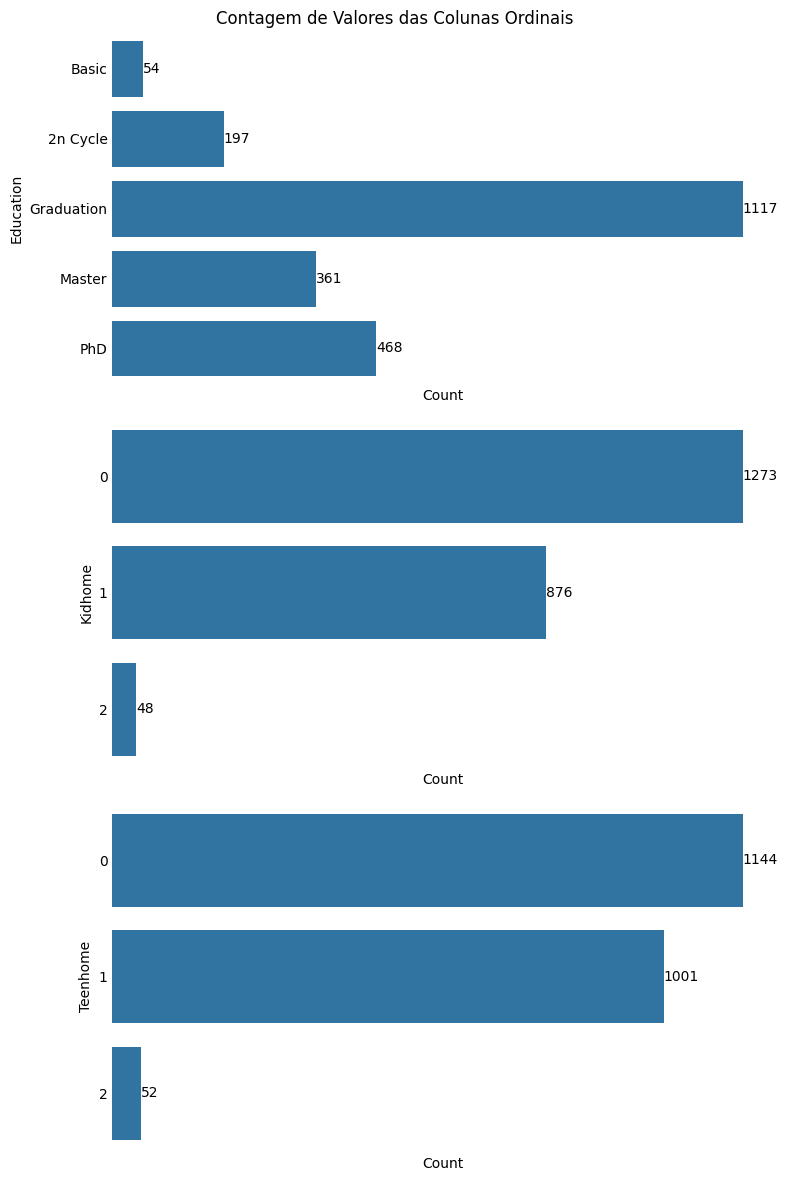

In [108]:
# Contagem de valores das colunas categóricas ordinais

fig, axs = plt.subplots(3, 1, figsize=(8, 12))

fig.suptitle("Contagem de Valores das Colunas Ordinais")

for ax, column, categories_order in zip(axs, ordinal_categoric_columns, categories_orders):

    count_data = pd.Categorical(
        df[column], 
        categories=categories_order, 
        ordered=True
        ).value_counts().sort_index()

    sns.barplot(
        y=count_data.index,
        x=count_data.values,
        ax=ax,
        orient='h',
    )

    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', size=0)
    ax.set_xticks([])
    
    ax.set_frame_on(False)

    ax.set_xlabel("Count")
    ax.set_ylabel(column)

    for container in ax.containers:

        ax.bar_label(container)

plt.tight_layout()
plt.show()

As três colunas de natureza ordinal (`Education`, `Kidhome` e `Teenhome`) possuem valores com baixíssima representatividade, que são 'Basic', 2 e 2, respectivamente. Na análise bivariada será decidido o que fazer com os registros com esses valores.